In [5]:
from mainfunc.converter import convert
from scipy.io import savemat

sample_rate = 30000   # sampling rate used by the electrodes
n_electrodes = 32   # number of electrodes

kilo_sorted_dir = '../../kiloSorted_Nana32'
session_id = 'n100122'
subsession_id = 's1'
subsession_path = session_id + '/' + subsession_id
dir_path = kilo_sorted_dir + '/' + subsession_path

k2p_dict = convert(dir_path, sample_rate, n_electrodes)

savemat('../k2o_mult.mat', k2p_dict)

original number of clusters: 113
cluster 33 missing.
cluster 45 missing.
cluster 52 missing.
cluster 64 missing.
cluster 77 missing.
cluster 85 missing.
cluster 90 missing.
cluster 91 missing.
cluster 101 missing.
cluster 102 missing.


In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from lib.simple_controller import SimpleController

dat_path = dir_path + '/temp_wh.dat' 
spike_times = np.load(dir_path + '/spike_times.npy')

sc = SimpleController(dir_path, dat_path, sample_rate, n_electrodes)
sc.n_spikes_waveforms = len(spike_times)  # maximum number of spikes to retrieve from one unit

# visualization example
# subplot_row_num = 9
subplot_row_num = 2
subplot_col_num = 3
subplot_num = subplot_row_num * subplot_col_num

def plot_waveforms(cluster_offset=0, n_spikes_to_visualize=sc.n_spikes_waveforms):
    figure(figsize=(subplot_col_num * 5, subplot_row_num * 3), dpi=80)
    for subplot_id in range(subplot_num):
        cluster_id = cluster_offset + subplot_id
        waveforms, _ = sc._get_waveforms(cluster_id)
        # waveforms.data: n_spikes, n_sample_time_points, n_channel_ranks                
        plt.subplot(subplot_row_num, subplot_col_num, subplot_id + 1)
        res = plt.plot(waveforms.data[:n_spikes_to_visualize,:,0].transpose())        
        plt.title('cluster ' + str(cluster_id) + ', main electrodes: ' + ','.join(waveforms.channel_labels[:5]))

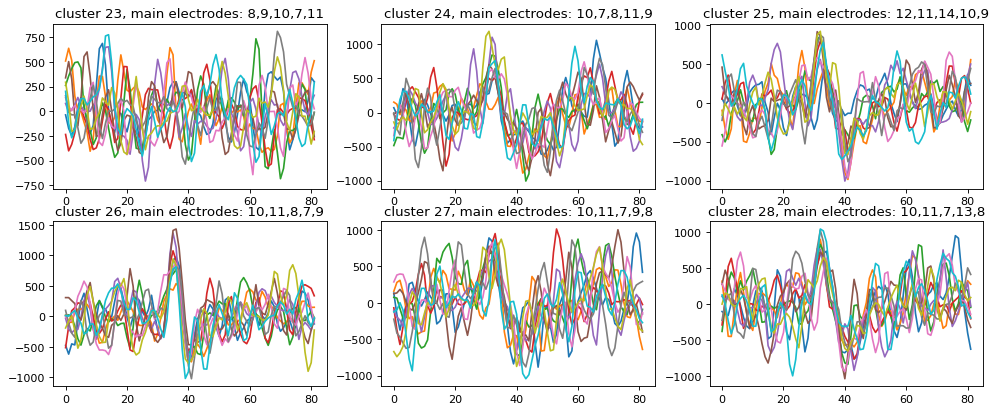

In [9]:
cluster_offset = np.random.randint(25)
plot_waveforms(cluster_offset=cluster_offset, n_spikes_to_visualize=10)

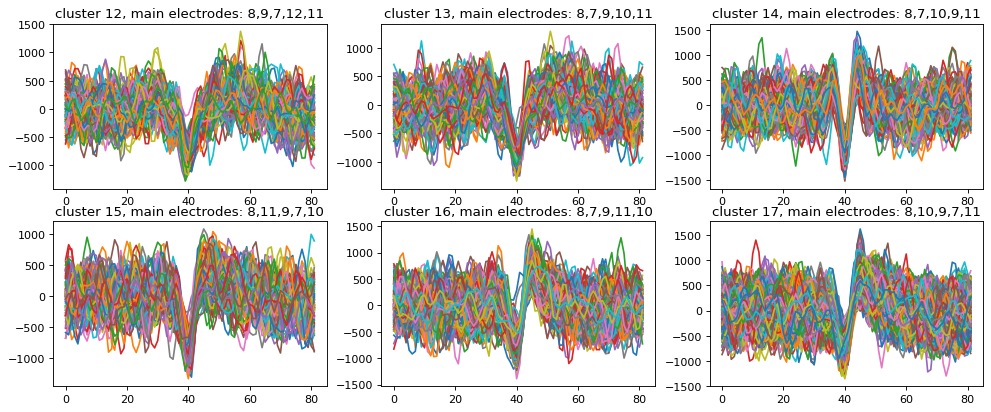

In [4]:
plot_waveforms(cluster_offset=cluster_offset)